<a href="https://colab.research.google.com/github/chiranjeet14/ML_Journey/blob/master/Hackerearth-Predict_condition_and_insurance_amount/train_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install xgboost > /dev/null

In [ ]:
import pandas as pd
import numpy as np
import io
import gc
import time
from pprint import pprint
# import PIL.Image as Image
# import matplotlib.pylab as plt
from datetime import date

# import tensorflow as tf
# import tensorflow_hub as hub

# settings
import warnings
warnings.filterwarnings("ignore")
gc.enable()

In [ ]:
# Calculating Precision, Recall and f1-score
def model_score(actual_value,predicted_values):
  from sklearn.metrics import confusion_matrix 
  from sklearn.metrics import accuracy_score 
  from sklearn.metrics import classification_report 
  from sklearn.metrics import recall_score
  
  actual = actual_value
  predicted = predicted_values
  results = confusion_matrix(actual, predicted) 
  
  print('Confusion Matrix :')
  print(results) 
  print('Accuracy Score :',accuracy_score(actual, predicted))
  print('Report : ')
  print(classification_report(actual, predicted))
  print('Recall Score : ')
  print(recall_score(actual, predicted))

In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gDrivePath = '/content/drive/MyDrive/Datasets/Hackerearth_vehicle_insurance_claim/dataset/'
gDriveTrainFinal = gDrivePath + 'final_datasets/train_final.csv'
gDriveTestFinal = gDrivePath + 'final_datasets/test_final.csv'

In [ ]:
df_train = pd.read_csv(gDriveTrainFinal)
df_test = pd.read_csv(gDriveTestFinal)

In [ ]:
df_train.head()

,image_name,Insurance_company,Cost_of_vehicle,Min_coverage,Max_coverage,Condition,Amount,year,month,day,dayofweek,week,weekofyear,dayofyear,days_in_month,currentYear-year,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,...,feature_1497,feature_1498,feature_1499,feature_1500,feature_1501,feature_1502,feature_1503,feature_1504,feature_1505,feature_1506,feature_1507,feature_1508,feature_1509,feature_1510,feature_1511,feature_1512,feature_1513,feature_1514,feature_1515,feature_1516,feature_1517,feature_1518,feature_1519,feature_1520,feature_1521,feature_1522,feature_1523,feature_1524,feature_1525,feature_1526,feature_1527,feature_1528,feature_1529,feature_1530,feature_1531,feature_1532,feature_1533,feature_1534,feature_1535,feature_1536
0,img_4513976.jpg,6,41500.0,1037.5,36142.68,0,0.0,2026,12,3,3,49,49,337,31,-5,1.113410,1.195830,0.678696,1.054544,1.535011,0.854014,1.052099,3.466827,4.109343,1.176659,0.710361,2.727606,1.701816,0.676628,1.243950,1.140115,1.558623,1.530318,1.403269,1.848212,1.663212,0.715508,0.331093,0.973033,...,1.362404,3.470226,2.212031,1.512656,2.512051,3.014310,0.479057,1.335440,0.888880,1.828558,2.093749,4.368773,0.466786,2.092361,1.186966,1.036144,2.313602,1.054223,1.080510,4.206156,0.553590,2.627964,1.034772,2.477546,1.833217,1.750974,1.316062,2.266628,2.354492,3.281885,0.213842,1.806247,2.196179,2.928731,0.667834,0.141059,1.338344,1.261466,2.091747,1.223898
1,img_7764995.jpg,6,50700.0,1267.5,12753.00,1,6194.0,2025,7,10,3,28,28,191,31,-4,1.184981,0.950404,0.987866,1.953136,1.191678,0.670103,1.153660,1.506774,1.693888,1.252585,1.366871,2.116124,0.971451,0.596697,2.564954,0.442221,0.510957,0.000000,4.434040,2.569827,2.152504,0.746451,1.133695,0.000000,...,2.215628,0.534555,1.324353,0.214095,1.976946,0.295753,1.400511,0.438756,1.751667,0.337908,3.021870,0.872242,0.489814,0.815823,0.690202,1.893319,1.511272,0.189446,1.334797,4.581714,0.818972,2.037291,0.306477,4.151568,1.217532,0.594016,0.589151,2.331535,2.162713,0.510852,0.865101,2.179245,0.134113,1.352904,1.690225,0.534583,0.372506,0.675020,0.601140,1.758329
2,img_451308.jpg,0,49500.0,1237.5,43102.68,0,0.0,2022,8,11,3,32,32,223,31,-1,0.984364,3.712041,1.342024,1.270731,2.592756,2.304238,1.083133,1.773062,3.126085,3.407647,3.253896,1.742563,0.880907,1.077093,2.729234,1.070258,2.239218,0.777536,3.829962,2.474639,2.073734,0.880441,0.938265,0.194889,...,3.207146,2.156034,1.728536,0.653108,1.860701,1.029206,1.212463,1.302829,2.240293,1.271308,2.979949,2.248640,0.497746,1.644486,3.073427,0.846062,3.447317,0.481213,2.883961,1.777015,1.299833,3.006877,1.301681,2.607335,0.980284,0.722226,0.881499,2.074486,1.128840,2.929870,0.678759,2.807421,0.461782,1.507994,0.231493,1.071761,1.353590,1.181578,0.724902,0.828650
3,img_7768372.jpg,0,33500.0,837.5,8453.00,1,7699.0,2022,8,2,1,31,31,214,31,-1,3.665247,1.350056,1.463427,1.000481,1.107578,0.338385,1.853880,2.324681,1.838981,2.579403,0.912768,3.552851,3.520501,1.570992,1.152532,0.670120,1.630700,0.527696,3.928166,3.351275,2.033791,1.283059,0.980372,2.746605,...,1.450805,1.738187,0.945829,3.028120,4.297032,1.605021,1.012109,1.490943,2.094949,1.577143,2.257676,0.688796,1.020116,1.583643,1.610365,1.145513,1.377197,2.338273,0.702233,3.547798,1.608444,2.860399,1.120848,3.461652,4.402316,1.495050,0.793155,4.184282,1.436624,0.643803,0.357418,4.112325,1.071358,1.469693,2.918353,0.943867,0.726660,2.254592,3.938456,1.160831
4,img_7765274.jpg,2,27600.0,690.0,6978.00,1,8849.0,2026,5,1,4,18,18,121,31,-5,2.131504,0.675391,0.120818,0.206190,1.625136,0.919565,2.832403,1.702231,2.569180,0.648237,2.386558,1.956236,2.153846,1.632268,3.885185,1.511744,2.223557,2.249133,4.072561,1.344050,1.149800,3.341234,1.496094,1.236094,...,3.394686,1.492867,1.545687,0.875928,2.120499,2.507311,3.624185,3.215530,2.551255,3.389349,2.079603,0.587104,4.669153,1

In [ ]:
df_train.sample(n = 10)

,image_name,Insurance_company,Cost_of_vehicle,Min_coverage,Max_coverage,Condition,Amount,year,month,day,dayofweek,week,weekofyear,dayofyear,days_in_month,currentYear-year,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,...,feature_1497,feature_1498,feature_1499,feature_1500,feature_1501,feature_1502,feature_1503,feature_1504,feature_1505,feature_1506,feature_1507,feature_1508,feature_1509,feature_1510,feature_1511,feature_1512,feature_1513,feature_1514,feature_1515,feature_1516,feature_1517,feature_1518,feature_1519,feature_1520,feature_1521,feature_1522,feature_1523,feature_1524,feature_1525,feature_1526,feature_1527,feature_1528,feature_1529,feature_1530,feature_1531,feature_1532,feature_1533,feature_1534,feature_1535,feature_1536
262,img_7764614.jpg,0,38600.0,965.0,9728.0,1,653.0,2025,3,8,5,10,10,67,31,-4,1.662419,0.707567,1.537157,1.130067,0.772054,1.338758,2.050071,3.108293,1.418544,2.876007,2.346354,1.329856,0.816538,1.665248,3.848615,0.688715,2.492432,1.446652,1.728203,1.999194,2.914221,4.269929,1.473858,1.576004,...,4.481093,1.629273,3.563246,0.665478,3.609000,1.659767,1.881376,1.009416,5.277202,0.992475,2.586953,1.533247,2.026746,1.487796,3.771282,1.636952,0.805579,1.021537,2.189279,3.745771,2.206246,0.903667,0.360997,3.199646,1.712968,2.830393,0.531194,0.904514,1.668719,0.844652,0.828608,3.156662,2.453210,1.502567,0.371135,1.250461,3.524782,0.837151,1.221327,2.585027
1386,img_4535269.jpg,1,47000.0,1175.0,11828.0,1,6525.0,2026,1,27,1,5,5,27,31,-5,4.384333,0.000000,0.480214,1.557579,1.780103,0.188606,0.630462,3.726027,2.439932,5.440098,1.947550,1.367023,2.253863,2.152632,2.249083,2.400692,2.028922,2.363577,3.253531,2.363015,2.829423,2.398155,2.932604,4.205000,...,3.236503,1.340734,2.870318,0.692594,4.615332,1.886852,2.529496,1.222149,1.885866,4.141741,2.269684,0.404417,2.906913,1.883264,3.447686,4.086735,1.758088,1.903611,1.509558,1.228084,4.499289,2.978872,0.498804,1.036839,1.518348,2.094525,1.475241,3.695946,0.676152,2.105377,0.344142,2.753111,2.502663,0.772361,0.126020,1.537485,0.660028,2.385829,1.550796,3.054872
861,img_4535672.jpg,3,47000.0,1175.0,11828.0,1,3632.0,2028,10,12,3,41,41,286,31,-7,1.811107,1.082089,1.806775,1.780868,0.739183,1.029000,0.715206,4.299066,0.657514,1.886155,2.446759,0.325653,0.792905,2.296535,2.775376,0.708549,1.493857,2.378338,0.404366,3.549392,2.184242,3.941408,1.254292,1.654963,...,2.091694,2.608286,3.152750,0.144358,3.003737,1.690171,1.425444,0.920649,0.833681,2.003977,2.512815,0.359611,1.455016,0.972519,3.530597,1.298503,0.451644,1.583467,5.104004,1.076688,0.654340,0.882300,0.182155,1.831318,1.555425,0.931941,3.519419,1.530260,1.167451,2.042930,0.811195,4.308520,0.000480,1.346043,0.847156,0.659682,3.993083,0.205310,0.374752,1.450156
976,img_4536731.jpg,1,50000.0,1250.0,12578.0,1,449.0,2028,6,17,5,24,24,169,30,-7,2.900842,2.124155,3.994361,1.181410,1.906700,0.597859,1.743863,2.778684,2.931598,2.061744,1.248666,1.881898,3.133924,3.019476,5.076402,3.529563,1.108708,3.346470,3.983725,2.064561,1.714165,3.286459,1.571613,0.552524,...,2.399955,2.402866,2.457253,1.778361,3.551786,2.274090,1.352243,1.104870,6.300429,1.655832,2.926004,2.012106,1.610331,2.165179,3.252494,1.769594,3.706473,2.549872,3.000427,5.289424,3.130261,2.250878,3.874808,3.088350,1.888301,2.456290,1.490097,2.299259,3.533566,2.213414,1.796243,3.392968,1.270131,3.619398,3.625020,1.650752,4.317417,2.236524,4.221175,2.719583
101,img_7768302.jpg,9,30200.0,755.0,7628.0,1,4138.0,2023,4,5,2,14,14,95,30,-2,1.288023,3.078751,2.339915,3.352126,1.251154,1.116979,1.448685,2.533358,1.540896,2.711232,3.057827,2.580267,3.880333,2.869576,4.498937,2.074251,1.667468,1.592260,1.524490,2.575783,1.621429,1.395584,1.565647,0.755772,...,2.411967,0.909401,1.462347,0.941883,2.123269,1.453508,2.599780,2.866101,1.974645,2.585334,2.298447,2.070664,0.5

In [ ]:
df_train.drop(['image_name'], axis=1, inplace=True)
df_test.drop(['image_name'], axis=1, inplace=True)

In [ ]:
df_train[['Insurance_company', 'Cost_of_vehicle', 'Min_coverage', 'Max_coverage', 'Condition', 'Amount']].isna().any()

Insurance_company    False
Cost_of_vehicle       True
Min_coverage          True
Max_coverage          True
Condition            False
Amount                True
dtype: bool

### Removing NaN in target variable

In [ ]:
# select rows where amount is not NaN
df_train = df_train[df_train['Amount'].notna()]
df_train[df_train['Amount'].isna()].shape

(0, 1551)

In [ ]:
# delete rows where Amount < 0
df_train = df_train[df_train['Amount'] >= 0]
df_train[['Cost_of_vehicle', 'Min_coverage', 'Max_coverage', 'Amount']].describe()

,Cost_of_vehicle,Min_coverage,Max_coverage,Amount
count,1301.000000,1301.000000,1301.000000,1387.000000
mean,37472.328978,936.808224,11259.900046,4120.832733
std,8918.789321,222.969733,7183.175604,3149.654210
min,11100.000000,277.500000,2853.000000,0.000000
25%,29800.000000,745.000000,7603.000000,1656.500000
50%,37300.000000,932.500000,9678.000000,4071.000000
75%,45200.000000,1130.000000,11703.000000,6040.000000
max,53500.000000,1337.500000,46495.680000,59844.000000


In [ ]:
selected_columns = ['Cost_of_vehicle', 'Min_coverage', 'Max_coverage']

# replacing nan values with median
from sklearn.impute import SimpleImputer 
imputer = SimpleImputer(missing_values = np.nan, strategy ='median') 
imputer = imputer.fit(df_train[selected_columns]) 

# Imputing the data      
df_train[selected_columns] = imputer.transform(df_train[selected_columns])
df_test[selected_columns] = imputer.transform(df_test[selected_columns])

In [ ]:
df_train[['Insurance_company', 'Cost_of_vehicle', 'Min_coverage', 'Max_coverage', 'Condition', 'Amount']].isna().any()

Insurance_company    False
Cost_of_vehicle      False
Min_coverage         False
Max_coverage         False
Condition            False
Amount               False
dtype: bool

### Checking if the dataset is balanced/imbalanced - Condition

Class 0 (No): 99
Class 1 (Yes): 1288
Proportion: 0.08 : 1


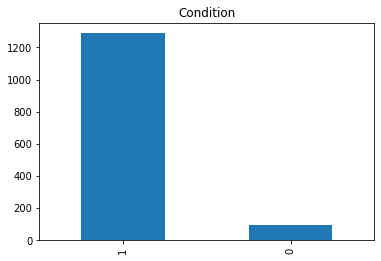

In [ ]:
# python check if dataset is imbalanced : https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

target_count = df_train['Condition'].value_counts()
print('Class 0 (No):', target_count[0])
print('Class 1 (Yes):', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Condition')

### Splitting Data into train-cv

In [ ]:
classification_labels = df_train['Condition'].values

# for regresion delete rows where Condition = 0
df_train_regression = df_train[df_train['Condition'] == 1]
regression_labels = df_train_regression['Amount'].values
######

df_train_regression.drop(['Condition','Amount'], axis=1, inplace=True)

df_train.drop(['Condition','Amount'], axis=1, inplace=True)
df_test.drop(['Condition','Amount'], axis=1, inplace=True, errors='ignore')

In [ ]:
# classification split
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(df_train, classification_labels, test_size=0.1)

### Over Sampling using SMOTE


In [ ]:
# https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
from imblearn.over_sampling import SMOTE
smote_overSampling = SMOTE()
X_train,y_train = smote_overSampling.fit_resample(X_train,y_train)
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 1159, 1: 1159}

### Scaling data

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_cv_scaled = scaler.transform(X_cv)

X_test_scaled = scaler.transform(df_test)
X_train_scaled

array([[-0.97543245, -1.47030142, -1.47030142, ...,  3.687905  ,
        -0.90122743,  0.27833218],
       [-0.62286991, -0.11053786, -0.11053786, ...,  2.28252877,
         1.43772368,  1.81620418],
       [-0.27030738,  0.4864315 ,  0.4864315 , ...,  0.0838075 ,
        -0.70240481,  3.582485  ],
       ...,
       [-0.19676015,  1.29245116,  1.29245116, ...,  0.05594413,
        -0.56855135,  0.10055639],
       [ 0.85289893, -1.3809815 , -1.3809815 , ...,  0.37873557,
        -0.54535121, -0.81962323],
       [ 0.6687185 ,  1.41877129,  1.41877129, ..., -1.15996618,
        -1.0433493 ,  0.14435198]])

## Modelling & Cross-Validation

### Classification

In [ ]:
%%time
# Train multiple models : https://www.kaggle.com/tflare/testing-multiple-models-with-scikit-learn-0-79425
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score

models = []

LogisticRegression = LogisticRegression(n_jobs=-1)
LinearSVC = LinearSVC()
KNeighbors = KNeighborsClassifier(n_jobs=-1)
DecisionTree = DecisionTreeClassifier()
RandomForest = RandomForestClassifier()
AdaBoost = AdaBoostClassifier()
Bagging = BaggingClassifier()
ExtraTrees = ExtraTreesClassifier()
GradientBoosting = GradientBoostingClassifier()
LogisticRegressionCV = LogisticRegressionCV(n_jobs=-1)
XGBClassifier = XGBClassifier(nthread=-1)

# models.append(("LogisticRegression",LogisticRegression))
# models.append(("LinearSVC", LinearSVC))
# models.append(("KNeighbors", KNeighbors))
# models.append(("DecisionTree", DecisionTree))
# models.append(("RandomForest", RandomForest))
models.append(("AdaBoost", AdaBoost))
# models.append(("Bagging", Bagging))
# models.append(("ExtraTrees", ExtraTrees))
# models.append(("GradientBoosting", GradientBoosting))
# models.append(("LogisticRegressionCV", LogisticRegressionCV))
# models.append(("XGBClassifier", XGBClassifier))

# metric_names = ['f1', 'average_precision', 'accuracy', 'precision', 'recall']
metric_names = ['f1']
results = []
names = []

nested_dict = {}

for name,model in models:
  nested_dict[name] = {}
  for metric in metric_names:
    print("\nRunning : {}, with metric : {}".format(name, metric))
    score = cross_val_score(model, X_train_scaled, y_train, n_jobs=-1, scoring=metric, cv=5)
    nested_dict[name][metric] = score.mean()


Running : AdaBoost, with metric : f1
CPU times: user 399 ms, sys: 150 ms, total: 548 ms
Wall time: 1min 13s


In [ ]:
import json
print(json.dumps(nested_dict, sort_keys=True, indent=4))

{
    "AdaBoost": {
        "f1": 0.9991397849462367
    }
}


### Regression

In [ ]:
X_train_regression, X_cv_regression, y_train_regression, y_cv_regression = train_test_split(df_train_regression, regression_labels, test_size=0.1)

scaler = StandardScaler()
X_train_scaled_regression = scaler.fit_transform(X_train_regression)
X_cv_scaled_regression = scaler.transform(X_cv_regression)

X_test_scaled_regression = scaler.transform(df_test)
X_train_scaled_regression

array([[-1.26021426,  0.12854886,  0.12854886, ...,  1.53402865,
        -0.20540802, -0.47918357],
       [ 0.01318446, -1.58875985, -1.58875985, ..., -1.10760405,
        -0.87314106, -0.71308165],
       [-0.30516522,  1.48615102,  1.48615102, ...,  0.05900373,
         0.88737542,  0.19042545],
       ...,
       [ 1.60493285,  1.40492696,  1.40492696, ...,  0.86252772,
        -0.35516626, -0.20092102],
       [-0.94186458,  1.04522041,  1.04522041, ...,  0.74664662,
         0.50906063,  0.69176517],
       [-0.30516522, -0.11512332, -0.11512332, ..., -0.07679806,
        -0.76744578, -0.18437826]])

In [ ]:
%%time
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score

models = []

LinearReg = LinearRegression(n_jobs=-1)
SGDReg = SGDRegressor()
SVReg = SVR()
LinearSVReg = LinearSVR()
KNeighborsReg = KNeighborsRegressor(n_jobs=-1)
DecisionTreeReg = DecisionTreeRegressor()
RandomForestReg = RandomForestRegressor(n_jobs=-1)
AdaBoostReg = AdaBoostRegressor()
BaggingReg = BaggingRegressor(n_jobs=-1)
ExtraTreesReg = ExtraTreesRegressor(n_jobs=-1)
GradientBoostingReg = GradientBoostingRegressor()
# XGBReg = XGBRegressor(nthread=-1)

# models.append(("LinearRegression",LinearReg))
# models.append(("SGDRegressor",SGDReg))
# models.append(("SVR", SVReg))
# models.append(("LinearSVR", LinearSVReg))
# models.append(("KNeighborsRegressor", KNeighborsReg))
# models.append(("DecisionTreeRegressor", DecisionTreeReg))
# models.append(("RandomForestRegressor", RandomForestReg))
# models.append(("AdaBoostRegressor", AdaBoostReg))
# models.append(("BaggingRegressor", BaggingReg))
models.append(("ExtraTreesRegressor", ExtraTreesReg))
# models.append(("GradientBoostingRegressor", GradientBoostingReg))
# models.append(("XGBReg", XGBRegressor))

# metric_names = ['f1', 'average_precision', 'accuracy', 'precision', 'recall']
metric_names = ['r2']
results = []
names = []

nested_dict = {}

# for name,model in models:
#   nested_dict[name] = {}
#   for metric in metric_names:
#     print("\nRunning : {}, with metric : {}".format(name, metric))
#     score = cross_val_score(model, X_train_scaled_regression, y_train_regression, n_jobs=-1, scoring=metric, cv=5)
#     nested_dict[name][metric] = score.mean()

CPU times: user 426 µs, sys: 0 ns, total: 426 µs
Wall time: 434 µs


In [ ]:
# import json
# print(json.dumps(nested_dict, sort_keys=True, indent=4))

In [ ]:
# # Hyperparameter tuning ExtraTreesRegressor

# # ExtraTreesRegressor(bootstrap=True, criterion='mae',n_estimators=100, warm_start=True,

# #                     max_depth=None, max_features='auto', max_leaf_nodes=None,
# #                     max_samples=None, min_impurity_decrease=0.0,
# #                     min_impurity_split=None, min_samples_leaf=1,
# #                     min_samples_split=2, min_weight_fraction_leaf=0.0,
# #                      n_jobs=-1, oob_score=False,
# #                     random_state=None, verbose=0)

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

model = ExtraTreesRegressor(n_jobs=-1, bootstrap=True, criterion='mae', warm_start=True, max_depth=9, max_features='auto')

param_grid = {
    # 'n_estimators': np.arange(100, 3000, 100, dtype=int),
    # 'criterion': ['mse', 'mae'],
    # 'max_depth': np.arange(5, 16, 1, dtype=int),
    # 'bootstrap': [True, False],
    # 'max_features': ['auto', 'sqrt', 'log2'],
    # 'max_features': np.arange(100, 1540, 20, dtype=int),
    # 'warm_start': [True, False],
}
                            
gsc = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=1000)
grid_result = gsc.fit(X_train_scaled_regression, y_train_regression)

# n_iter_search = 100
# random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=n_iter_search, scoring='r2', cv=3, n_jobs=-1, verbose=500)
# random_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 17.5min remaining: 11.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 22.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 22.3min finished


In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.062463 using {}


### Predicting on CV data

In [ ]:
classification_alg = AdaBoost
# regression_alg = ExtraTreesReg

# hypertuned model
regression_alg = gsc

classification_alg.fit(X_train_scaled, y_train)
regression_alg.fit(X_train_scaled_regression, y_train_regression)


# predictions_class = classification_alg.predict(X_cv)
# pprint(classification_alg.get_params())

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 17.5min remaining: 11.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 22.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 22.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=ExtraTreesRegressor(bootstrap=True, ccp_alpha=0.0,
                                           criterion='mae', max_depth=9,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           max_samples=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=200, n_jobs=-1,
                                           oob_score=False, random_state=None,
                                           verbose=0, warm_start=True),
             iid='deprecated', n_jobs=-1, param_grid={},
          

In [ ]:
# model_score(y_cv,predictions)

### Predicting on test Data

In [ ]:
trained_classifier = classification_alg
trained_regressor = regression_alg

predictions_trained_classifier_test = trained_classifier.predict(X_test_scaled)
predictions_trained_regressor_test = trained_regressor.predict(X_test_scaled_regression)

In [ ]:
read = pd.read_csv(gDrivePath + 'test.csv')
submission = pd.DataFrame({
        "Image_path": read["Image_path"],
        "Condition": predictions_trained_classifier_test,
        "Amount": predictions_trained_regressor_test
    })

In [ ]:
submission.head()

,Image_path,Condition,Amount
0,img_4538519.jpg,1,2944.5000
1,img_7766002.jpg,1,3576.1050
2,img_4637390.jpg,1,4813.4750
3,img_4516108.jpg,1,4473.5125
4,img_4517008.jpg,1,4839.3225


In [ ]:
submission['Amount'][submission.Condition == 0] = 0

In [ ]:
submission[submission['Condition'] == 0].sample(n = 10)

,Image_path,Condition,Amount
296,img_776833.jpg,0,0.0
576,img_7762330.jpg,0,0.0
554,img_4638685.jpg,0,0.0
216,img_4531081.jpg,0,0.0
504,img_4518393.jpg,0,0.0
509,img_4518899.jpg,0,0.0
322,img_453909.jpg,0,0.0
325,img_4513365.jpg,0,0.0
81,img_4512558.jpg,0,0.0
99,img_4533213.jpg,0,0.0


In [ ]:
submission.Amount = submission.Amount.round()
submission.head()

,Image_path,Condition,Amount
0,img_4538519.jpg,1,2944.0
1,img_7766002.jpg,1,3576.0
2,img_4637390.jpg,1,4813.0
3,img_4516108.jpg,1,4474.0
4,img_4517008.jpg,1,4839.0


In [ ]:
submission.to_csv('./submission.csv', index=False)